In [2]:
!pip install torchsummary

In [3]:
import os
import pandas as pd

import os
import cv2
import pandas as pd
import torch
import torchvision
from torchvision import io
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
import torchaudio

from collections import OrderedDict
import math, random
from torchaudio import transforms
from IPython.display import Audio
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
import torch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cuda'

In [5]:
data_path = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

image_files = []
masks = []
folds = os.listdir(data_path)
folds.remove("README.md")
folds.remove("data.csv")
for fold in folds:
    fold_path = os.path.join(data_path, fold)
    for image in os.listdir(fold_path):
        if image[-8:-4] != "mask":
            image_files.append(os.path.join(fold, image))
            image_mask =  image.split('.')[0] + '_mask.'+ image.split('.')[1]
            if image_mask in os.listdir(fold_path):
                masks.append(os.path.join(fold, image_mask))
image_file = pd.Series(image_files)
mask = pd.Series(masks)
results = pd.concat([image_file, mask], axis=1)
df = pd.DataFrame(results)
df.columns = ['image_file', 'mask']
        

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_file  3929 non-null   object
 1   mask        3929 non-null   object
dtypes: object(2)
memory usage: 61.5+ KB


In [7]:
print(df.loc[0, 'image_file'])
print(df.loc[0, 'mask'])

TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45_mask.tif


In [8]:
X = df['image_file'].values
y = df['mask'].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

3536 3536
393 393


In [9]:
print(X_train[0])
print(y_train[0])

TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_3.tif
TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_3_mask.tif


In [26]:
class MRIBrainDS(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        image_file = os.path.join(data_path, self.X[idx])
        image = cv2.imread(image_file)
        image = cv2.resize(image, (224, 224))
        image = torch.from_numpy(image).permute(2, 0, 1)
        image = image.to(torch.float32)
        
        mask_file = os.path.join(data_path, self.y[idx])
        mask = cv2.imread(mask_file)
        mask = cv2.resize(mask, (224, 224))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = np.array([mask])
        mask = torch.from_numpy(mask)
        mask = mask.to(torch.float32)
        
        
        return image, mask 
        
        

In [27]:
train_data = MRIBrainDS(X_train, y_train)
test_data = MRIBrainDS(X_test, y_test)

In [28]:
batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([8, 3, 224, 224])
Shape of y: torch.Size([8, 1, 224, 224]) torch.float32


In [38]:
len(train_dataloader)

442

In [29]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super().__init__()
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

model =UNet().to(device)
print(model)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [30]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,216
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,432
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,864
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

In [31]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

In [33]:
loss_fn = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [39]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        #X = X.to(torch.float32)
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    print(f"loss: {loss:>7f}")

In [40]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            #X = X.to(torch.float32)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    #correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

In [41]:
epochs = 50
min_test_loss = 9999
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    if test_loss<min_test_loss:
        min_test_loss = test_loss
        torch.save(model.state_dict(), "saved_model.pth")
        print("save model")
        
print("Done!")

Epoch 1
-------------------------------
loss: -0.781697  [    8/ 3536]
loss: -0.773554  [  808/ 3536]
loss: -0.576021  [ 1608/ 3536]
loss: -0.448982  [ 2408/ 3536]
loss: -0.667489  [ 3208/ 3536]
loss: -0.903883
Test Error: 
 Avg loss: -0.702885 

save model
Epoch 2
-------------------------------
loss: -0.863244  [    8/ 3536]
loss: -0.838204  [  808/ 3536]
loss: -0.645748  [ 1608/ 3536]
loss: -0.559139  [ 2408/ 3536]
loss: -0.682568  [ 3208/ 3536]
loss: -0.909596
Test Error: 
 Avg loss: -0.714358 

save model
Epoch 3
-------------------------------
loss: -0.877698  [    8/ 3536]
loss: -0.823240  [  808/ 3536]
loss: -0.602027  [ 1608/ 3536]
loss: -0.611791  [ 2408/ 3536]
loss: -0.717395  [ 3208/ 3536]
loss: -0.934394
Test Error: 
 Avg loss: -0.748404 

save model
Epoch 4
-------------------------------
loss: -0.910962  [    8/ 3536]
loss: -0.857642  [  808/ 3536]
loss: -0.623900  [ 1608/ 3536]
loss: -0.624904  [ 2408/ 3536]
loss: -0.779988  [ 3208/ 3536]
loss: -0.906668
Test Error: 
 A

In [42]:
class InfeDS(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        image_file = os.path.join(data_path, self.X[idx])
        image = cv2.imread(image_file)
        image = cv2.resize(image, (224, 224))
        image = torch.from_numpy(image).permute(2, 0, 1)
        
        return image
        
        

In [43]:
def Prediction1(image_path, model):
    file_paths = []
    masks = []
    file_paths.append(image_path)
    X_infe = np.array(file_paths)
    infe_data = InfeDS(X_infe)
    infe_dataloader = DataLoader(infe_data, batch_size=1)

    for X in infe_dataloader:
        X = X.to(torch.float32)
        X = X.to(device)
        y_pred = model(X)
        return y_pred

In [121]:
image_path = os.path.join(data_path, X_test[9])
mask_path = os.path.join(data_path, y_test[9])
a = Prediction1(image_path, model)
mask = a[0][0]
mask = mask.cpu().detach().numpy()

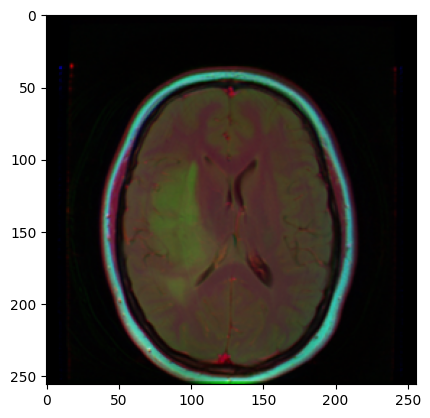

In [122]:
image = cv2.imread(image_path)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

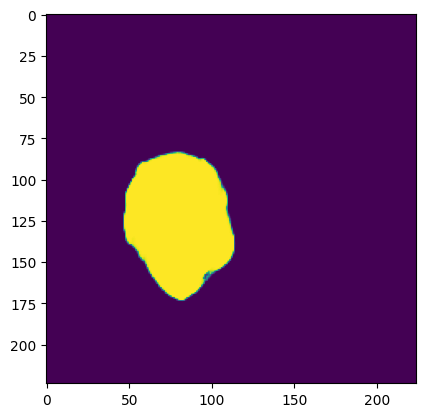

In [123]:
plt.imshow(mask)
plt.show()

In [124]:
resize_image = cv2.resize(image, (224, 224))
gray_image = cv2.cvtColor(resize_image, cv2.COLOR_BGR2GRAY)
gray_image.shape

(224, 224)

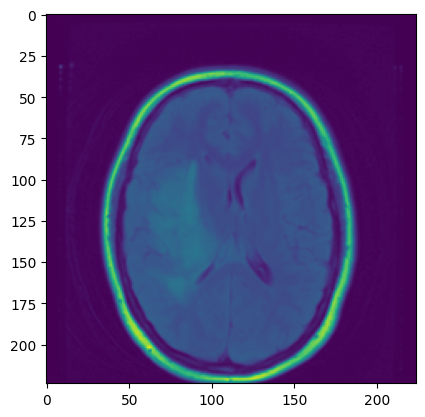

In [125]:
plt.imshow(gray_image)
plt.show()

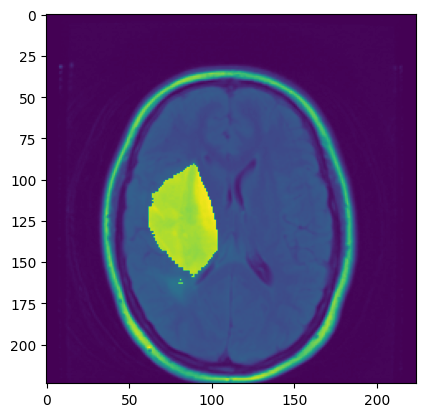

In [126]:
seg_image = np.zeros((224, 224))
for i in range(gray_image.shape[0]):
    for j in range(gray_image.shape[1]):
        if mask[i][j] == 1:
            seg_image[i][j] = 255 - gray_image[i][j]
            #seg_image[i][j] = 25
        else:
            seg_image[i][j] = gray_image[i][j]
plt.imshow(seg_image)
plt.show()
        

In [45]:
a[0].shape

torch.Size([1, 224, 224])

In [46]:
a[0][0].shape

torch.Size([224, 224])

In [48]:
img = a[0][0]

In [49]:
img = img.cpu().detach().numpy()
img.shape

(224, 224)

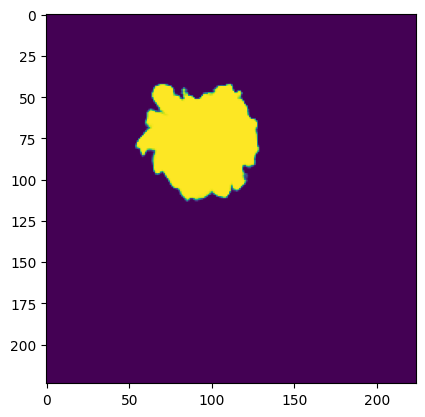

In [50]:
plt.imshow(img)
plt.show()

In [110]:
for X, y in train_dataloader:
    print(type(X))
    print(type(y))
    break

<class 'torch.Tensor'>
<class 'torch.Tensor'>
